In [1]:
import os
import numpy as np
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# === PATHS ===
SCRIPT_PATH = os.getcwd()
DATA_DIR = os.path.abspath(os.path.join(SCRIPT_PATH, '..', '..', 'data', 'preprocessed', 'time_window_data'))
MODELS_DIR = os.path.abspath(os.path.join(SCRIPT_PATH, '..', '..', 'models', 'lstm'))
os.makedirs(MODELS_DIR, exist_ok=True)

In [3]:
INPUT_SHAPE = (100, 2)  # (timesteps, features) - from WINDOW_SIZE=100, features=['CURRENT (A)', 'ROTO (RPM)']
NUM_CLASSES = 4
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001

In [4]:
# === LOAD PREPROCESSED DATA ===
train_data = np.load(os.path.join(DATA_DIR, 'train.npz'))
X_train = train_data['X']
y_train = train_data['y']
unique_train, counts_train = np.unique(y_train, return_counts=True)
print("Class distribiution in train set:", dict(zip(unique_train, counts_train)))

val_data = np.load(os.path.join(DATA_DIR, 'val.npz'))
X_val = val_data['X']
y_val = val_data['y']
unique_val, counts_val = np.unique(y_val, return_counts=True)
print("Class distribiution in validation set:", dict(zip(unique_val, counts_val)))

test_data = np.load(os.path.join(DATA_DIR, 'test.npz'))
X_test = test_data['X']
y_test = test_data['y']
unique_test, counts_test = np.unique(y_test, return_counts=True)
print("Class distribiution in test set:", dict(zip(unique_test, counts_test)))

# Load label encoder to get class names and number of classes
le = joblib.load(os.path.join(DATA_DIR, 'label_encoder.pkl'))
NUM_CLASSES = len(le.classes_)  # Update NUM_CLASSES if needed

# Convert labels to one-hot encoding for categorical crossentropy
y_train_cat = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val_cat = to_categorical(y_val, num_classes=NUM_CLASSES)
y_test_cat = to_categorical(y_test, num_classes=NUM_CLASSES)
print(f"Classes: {le.classes_}")

Class distribiution in train set: {np.int64(0): np.int64(25568), np.int64(1): np.int64(25568), np.int64(2): np.int64(25568), np.int64(3): np.int64(25568)}
Class distribiution in validation set: {np.int64(0): np.int64(5593), np.int64(1): np.int64(5593), np.int64(2): np.int64(5593), np.int64(3): np.int64(5593)}
Class distribiution in test set: {np.int64(0): np.int64(5593), np.int64(1): np.int64(5593), np.int64(2): np.int64(5593), np.int64(3): np.int64(5593)}
Classes: ['faulty' 'faulty_zip' 'healthy' 'healthy_zip']


In [5]:
# === Monte Carlo Dropout ===
class MCDropout(Dropout):
    """
    Custom Dropout layer that is ALWAYS active, even during inference.
    Required for Monte Carlo Uncertainty Estimation.
    """
    def call(self, inputs):
        return super().call(inputs, training=True)

In [6]:
model = Sequential([
    Input(shape=INPUT_SHAPE),
    LSTM(units=128, return_sequences=False),
    MCDropout(0.2),
    Dense(64, activation='relu'),
    MCDropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_dropout (MCDropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_dropout_1 (MCDropout)        │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,588 (295.27 KB)

 Trainable params: 75,588 (295.27 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# === CALLBACKS ===
checkpoint_path = os.path.join(MODELS_DIR, 'best_lstm_model.keras')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]

In [8]:
# === TRAINING ===
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6781 - loss: 0.5861
Epoch 1: val_loss improved from None to 0.20685, saving model to C:\Users\Jakub\Kuba_lokalne\studia\Praca_magisterska\Projekt\Fault-detection-in-mechanical-devices\models\lstm\best_lstm_model.keras
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 76s 23ms/step - accuracy: 0.7688 - loss: 0.4478 - val_accuracy: 0.9106 - val_loss: 0.2068 - learning_rate: 0.0010
Epoch 2/50
3194/3196 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8632 - loss: 0.2828
Epoch 2: val_loss improved from 0.20685 to 0.20477, saving model to C:\Users\Jakub\Kuba_lokalne\studia\Praca_magisterska\Projekt\Fault-detection-in-mechanical-devices\models\lstm\best_lstm_model.keras
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 80s 25ms/step - accuracy: 0.8727 - loss: 0.2686 - val_accuracy: 0.9029 - val_loss: 0.2048 - learning_rate: 0.0010
Epoch 3/50
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9014 - loss: 0.2146
Epoch 3: val_loss did not improve from 0.204

In [11]:
# === EVALUATION ===
test_loss, test_acc = model.evaluate(X_test, y_test_cat)

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Unique classes in y_te st:", np.unique(y_test))
print("Unique classes in y_pred_classes:", np.unique(y_pred_classes))
print("y_test class counts:", np.bincount(y_test))
print("y_pred_classes class counts:", np.bincount(y_pred_classes))

# Accuracy
test_acc = accuracy_score(y_test, y_pred_classes)
print(f"Test Accuracy: {test_acc:.4f}")

# Determine present classes and corresponding names
unique_classes = np.unique(np.concatenate((y_test, y_pred_classes)))
labels = np.arange(NUM_CLASSES)
target_names = le.classes_

# Print classification report and confusion matrix with adjusted labels
print("Classification Report:\n", classification_report(y_test, y_pred_classes, labels=labels, target_names=target_names, zero_division=0))


700/700 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9482 - loss: 0.1208
700/700 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step
Unique classes in y_te st: [0 1 2 3]
Unique classes in y_pred_classes: [0 1 2 3]
y_test class counts: [5593 5593 5593 5593]
y_pred_classes class counts: [5589 5597 5714 5472]
Test Accuracy: 0.9490
Classification Report:
               precision    recall  f1-score   support

      faulty       1.00      1.00      1.00      5593
  faulty_zip       1.00      1.00      1.00      5593
     healthy       0.89      0.91      0.90      5593
 healthy_zip       0.91      0.89      0.90      5593

    accuracy                           0.95     22372
   macro avg       0.95      0.95      0.95     22372
weighted avg       0.95      0.95      0.95     22372



<Figure size 800x600 with 0 Axes>

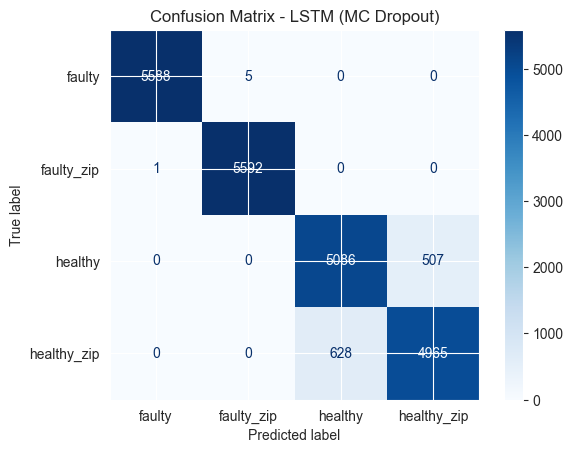

In [13]:
# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - LSTM (MC Dropout)")
plt.show()

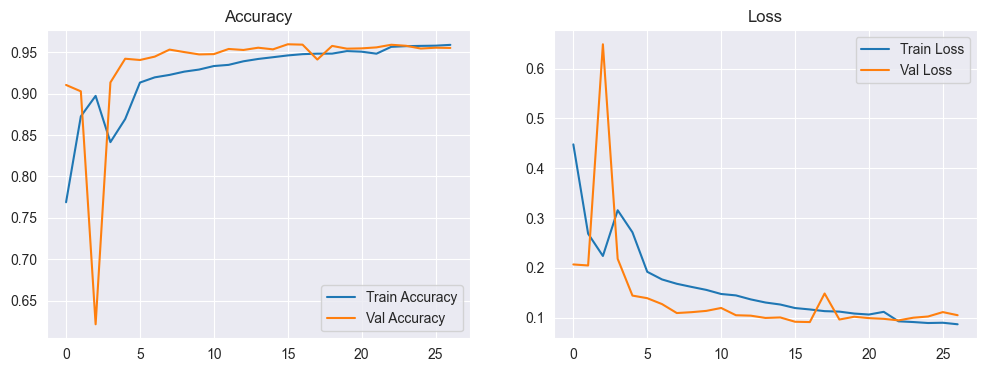

In [14]:
# === TRAINING HISTORY PLOT ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [15]:
# === SAVING ARTIFACTS ===
# Model is already saved by ModelCheckpoint, but we can save the final state too
final_model_path = os.path.join(MODELS_DIR, 'lstm_mcdropout_final.keras')
model.save(final_model_path)
print(f"\nFinal model saved to: {final_model_path}")



Final model saved to: C:\Users\Jakub\Kuba_lokalne\studia\Praca_magisterska\Projekt\Fault-detection-in-mechanical-devices\models\lstm\lstm_mcdropout_final.keras
